In [1]:
import numpy as np
import tensorflow as tf
import utils, imp
from functools import partial

Before we use any sentiment training, it might be worth exploring, which words are in any way determining labels. There are more than 70k words, so learning matrices capable of processing vectors that huge is going to take forever. Most of them is going be not so informative - for instance, words like 'I', 'the', 'will', 'be', 'want' are most likely going to occur in every label with roughly the same probability. 

What I will want to find, will be how distributions of joint probability $P( W, L )$ diverges from independence assumptions $P( W, L ) = P(W)P(L)$. 

What models am I going to build? First one will be simple Naive Bayes. I will test for occurence of given word, its count and Tf-Idf score. I will use CountVectorizer and TfidfVectorizer from sci-kit learn package. Moreover, using vectors given by these models as inputs, I will build simple logistic regression and neural network with one hidden layer. Another model I'm curious to check out would be average over word embeddings in sentence. At last, I will reach recurrent neural networks, which I expect to explore more deeply.

Due to desire to keep this notebook somewhat clean and readable, I'm storing both all of my helper functions and models in separate files. I will try to explain what is going on, but they are easily checkable.

In [2]:
dataset, test = utils.load_and_train_test_split(keywords=['technology', 'design', 'entertainment'], train_size=.7)

#it loads and shuffles my training data from TED dataset. Here used with default parameters. Under the hood, it also
#does some basic preprocessing - turns to lowercase, deletes numbers and diactric signs

x_train, y_train = list(zip(*dataset))
y_train, labels_readable = utils.transform_labels_usable(y_train)

x_test, y_test = list(zip(*test))
y_test = utils.transform_labels_usable(y_test)[0]

In [3]:
data = x_train, y_train, x_test, y_test

In [4]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([796, 111, 116,  19, 271,  23, 100,  23]))

Classes are highly imbalanced. This is going to be a problem.

I'm going to need some plotting device. Matplotlib is indispensable.

In [5]:
import matplotlib.pyplot as plt

In order to determine most useful words, I will need some metric of difference between two distributions of probability - first one being proportional to labels' frequency in dataset and other one conditioned by word. There are two common ways to do this - first one is called mutual information score, second is Chi-Squared test. 

$$ MI = \sum_{w_i \in W} \sum_{l_j \in L} P( w = w_i, l = l_j ) \log \frac{P( w = w_i, l = l_j )}{P( w = w_i) P(l = l_j)} $$

Those of you familiar with statistics can recognize this as cross entropy - basically we are testing how different our joint distribution is from distributions that holds independence assumption.

Chi-Squared test also tests this difference, but with more straightforward way.

$$ \tilde{\chi}^2 = \sum_{w_i \in W} \sum_{l_j \in L} \frac{\left( N_{ w_i, l_j} - E_{  w_i, l_j } \right)^2}{E_{ w_i, l_j }}$$

where $N_{ w = w_i, l = l_j}$ is number of real occurences of both word and label and $E_{ w = w_i, l = l_j }$ is number of occurence should these two factors were independent. $\tilde{\chi}^2$ is probability distribution - if it is in 

Fortunately, I don't have to write this pretty straightforward functions myself - sci-kit learn package is going to do all tedious processing.

In [6]:
from sklearn.feature_selection import chi2, mutual_info_classif

First things first, I can't really use all the words. Many of them occurs only once, so it would be basically relying on chance. I have to assert that every $P( w = w_i, l = l_j )$ is greater than zero, at the very least.

In [7]:
word_counts = utils.count_words(x_train)

In [8]:
proportions_dict = utils.calculate_probs_occurence(word_counts.keys(), x_train, y_train)

Let's check number of words fulfilling the condition of having at least 20 occurences in every class. Apart from that, I will test for showing up in at least ten percent of documents.

In [9]:
perc_threshold = int(len(x_train)/10)
occ_threshold = 20

In [10]:
at_least_occ = list(filter(lambda x: np.all(proportions_dict[x] > occ_threshold), proportions_dict.keys()))
at_least_threshold = list(filter(lambda x: np.sum(proportions_dict[x])>perc_threshold, proportions_dict.keys()))

In [11]:
len(at_least_occ)

0

Well, that was unexpected

In [12]:
len(at_least_threshold)

1118

In [13]:
at_least_5 = list(filter(lambda x: np.all(proportions_dict[x]>5), proportions_dict.keys()))

In [14]:
len(at_least_5)

300

All in all, everything will be determined be final score of the estimator - maybe someone more skilled in statistics would be able to predict, which approach is going to yield better accuracy of predictions? Before I get around to testing predictors, it's time to check how these sets encapsulate each other.

In [15]:
len(set(at_least_threshold) - set(at_least_5))

818

Before I do any feature engineering, let's check how simple models are going to perform on last two sets of words. I will use three vectorizers and three different models, respectively. Binary count vectorizer will select features for Bernoulli Naive Bayes ( further NB ), ordinary count vectorizer will produce inputs for Multinomial NB and tf-idf vectorizer will fabricate samples for Gaussian NB.

What do I mean by text vectorizer? Well, it is simply function that takes some given sequence of words as input and outputs some vector of numbers - be it integers or reals. For instance, for dictionary of words of size $N$, vectorizer will output vector of size $N$. Number on $i$-th position will be representing frequency, occurence (or lack thereof) of $i$-th word. In binary vectorizer, it will be 1 if word was found in given text and zero otherwise. In count vectorizer, it is going be number of times word was found in text. Misterious tf-idf vectorizer will return number produced by equation: $\frac{\#w_{ji}}{\#w_j} \cdot \frac{N}{\log 1 + D_{w_i} }$, where $w_j$ denotes number of words in document, $w_{ji}$ number of times word $w_i$ can be found in $D_j$ and $D_{w_i}$ is number of documents which one can find $w_i$ in.

In [16]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score

I've decided to import accuracy_score only for brevity - displaying confusion matrix, while useful, is going to take up a lot of place in this notebook. It would be reasonable for one classifier, but not for six of them (two vocab sets, three models ). Since this is multiclass problem, I can't really use other metrics such as precision and recall out of the box - I would have to turn this into multiple binary classification problems.

In [17]:
BinaryVectorizer = partial(CountVectorizer, binary=True)

In [18]:
imp.reload(utils)

<module 'utils' from '/home/lukasz/Dokumenty/DEEP LEARNING/NLP/oxford/utils.py'>

In [41]:
overall_scores = []
pips = []
vect_model = list(zip([BinaryVectorizer, CountVectorizer, TfidfVectorizer],[BernoulliNB, MultinomialNB, GaussianNB]))
for vocab in [at_least_5, at_least_threshold]:
    
    for i in range(3):
        
        vectorizer, model = vect_model[i]
        params = {
            'vectorizer':vectorizer,
            'model':model,
            'vocabulary':vocab,
            'data':data
        }
        score, pip = utils.train_test_pipeline(**params)
        overall_scores.append(score)
        pips.append(pip)

In [43]:
overall_scores

[{'test': 0.40894568690095845, 'train': 0.46196024674434544},
 {'test': 0.42971246006389774, 'train': 0.48320767649074708},
 {'test': 0.40734824281150162, 'train': 0.5476353666895134},
 {'test': 0.46325878594249204, 'train': 0.60795065113091162},
 {'test': 0.51118210862619806, 'train': 0.62919808087731321},
 {'test': 0.52396166134185307, 'train': 0.78272789581905411}]

In [46]:
score, pip = utils.train_test_pipeline(vectorizer=BinaryVectorizer, model=MultinomialNB, vocabulary=at_least_threshold, data=data)

In [47]:
score, pip

({'test': 0.52715654952076674, 'train': 0.70185058259081567},
 Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words=None,
    ...     validate=True)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]))

In [48]:
overall_scores.append(score)
pips.append(pip)

Unexpected winner

In [19]:
from sklearn.metrics import precision_score, recall_score

In [52]:
predictions = pips[-1].predict(x_test)

In [72]:
for i in range(1,5):
    
    predictions = pips[-i].predict(x_test)
    print({n:np.round(utils.test_score_one_vs_all(predictions, y_test, func), 2).tolist()
           for n, func in zip(['precision', 'recall'], [precision_score, recall_score])})

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'recall': [0.6, 0.58, 0.37, 0.0, 0.53, 0.14, 0.26, 0.0], 'precision': [0.75, 0.26, 0.45, 0.0, 0.44, 0.17, 0.25, 0.0]}
{'recall': [0.63, 0.4, 0.41, 0.0, 0.51, 0.0, 0.26, 0.0], 'precision': [0.74, 0.39, 0.28, 0.0, 0.39, 0.0, 0.22, 0.0]}
{'recall': [0.54, 0.66, 0.48, 0.0, 0.55, 0.0, 0.31, 0.12], 'precision': [0.78, 0.32, 0.46, 0.0, 0.4, 0.0, 0.26, 0.11]}
{'recall': [0.52, 0.44, 0.28, 0.0, 0.58, 0.0, 0.13, 0.0], 'precision': [0.74, 0.16, 0.39, 0.0, 0.38, 0.0, 0.28, 0.0]}


Not very impressive - we see that rare classes were rarely ( mostly not at all ) correctly labeled.



Finally, it's time to select best features, so I can be honest while comparing scores of different classifiers. It would not be very wise to give verdict "Naive Bayes is crap" while not taking elementary steps to make it a little bit better.

I'll start off with MIS. Also, since this is neither production-level analysis nor Kaggle contest, I will use only two best-performing models from previous pipeline - which means Multinomial Naive Bayes on top of Binary Vectorizer and Gaussian NB on top of Tf-idf. It does not mean, of course, that some other model would not outperform this one with less number of irrelevant words.

Abstraction of an abstraction ;)

In [119]:
imp.reload(utils)

<module 'utils' from '/home/lukasz/Dokumenty/DEEP LEARNING/NLP/oxford/utils.py'>

In [35]:
from sklearn.preprocessing import FunctionTransformer, Normalizer, StandardScaler
from sklearn.feature_selection import SelectKBest

In [121]:
params = {
            'vocabulary':vocab,
            'data':data
        }

gparams = {
    'model':GaussianNB,
    'vectorizer':TfidfVectorizer
}

gparams.update(params)

bparams = {
    'model':MultinomialNB,
    'vectorizer':BinaryVectorizer
}

bparams.update(params)

binary = []
gauss = []

for k in range(100, 1200, 100):
    
    mic = {'selection_func':mutual_info_classif, 'k':k}
    bparams.update(mic)
    bscore, pip = utils.feature_selection_pipeline(**bparams)
    
    gparams.update(mic)
    gscore, pip = utils.feature_selection_pipeline(**gparams)
    
    bparams.update({'selection_func':chi2})
    bscore_2, pip = utils.feature_selection_pipeline(**bparams)
    
    gparams.update({'selection_func':chi2})
    gscore_2, pip = utils.feature_selection_pipeline(**gparams)
    
    binary.append(( bscore['test'], bscore_2['test'] ))
    gauss.append((gscore['test'], gscore_2['test']))
    
    print(k)

100
200
300
400
500
600
700
800
900
1000
1100


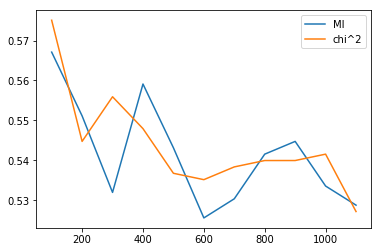

In [133]:
m, c = list(zip(*binary))
r = range(100, 1200, 100)
plt.plot(r, m, label='MI')
plt.plot(r, c, label=r'chi^2')
plt.legend(loc='best')
plt.show()

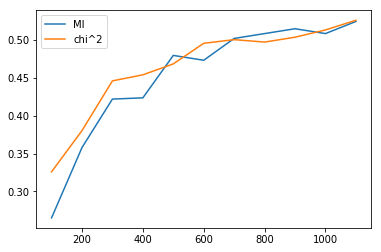

In [134]:
m, c = list(zip(*gauss))
r = range(100, 1200, 100)
plt.plot(r, m, label='MI')
plt.plot(r, c, label=r'chi^2')
plt.legend(loc='best')
plt.show()

Apparently Gaussian classifier does better and better with more data, while binary one worsens its performance, needing highly selective features

In [135]:
bparams['k'] = 10

In [136]:
bscore, pip = utils.feature_selection_pipeline(**bparams)

In [137]:
bscore

{'test': 0.57987220447284349, 'train': 0.56751199451679235}

In [138]:
utils.test_score_one_vs_all(pip.predict(x_test), y_test, precision_score)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.58626760563380287, 0.0, 1.0, 0.0, 0.5, 0.0, 0.0, 0.0]

In [139]:
utils.test_score_one_vs_all(pip.predict(x_test), y_test, recall_score)

[0.96242774566473988,
 0.0,
 0.043478260869565216,
 0.0,
 0.23333333333333334,
 0.0,
 0.0,
 0.0]

I knew that there is a catch. Turns out that label imbalance is bigger problem than I've thought. While naive bayes has no way of battling this phenomenon, one might introduce sample weights into logistic regression - which is classifier I'm going to turn my attention into.

In [21]:
from sklearn.linear_model import LogisticRegression

How am I going to weight samples? One method is to use $w_i = \frac{N}{K*n_i}$, where $N$ is number of samples, $K$ number of classes and $n_i$ number of samples with $i$ class. Another would be to split training in batches, uniformly filled with all of the classes. While the former is straighforward with sklearn - one has to switch one argument while defining estimator, latter will be a bit of a hassle.

In [22]:
balance = len(x_train)/np.unique(y_train, return_counts=True)[1]

In [202]:
scores, pip = utils.train_test_pipeline(TfidfVectorizer, LogisticRegression, data, at_least_threshold)

print(scores)

{'train': 0.59287183002056199, 'recall': 0.14684190960877944, 'precision': 0.24206684362934361, 'test': 0.57827476038338654}


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [203]:
scores, pip = utils.train_test_pipeline(TfidfVectorizer, LogisticRegression, data, at_least_threshold, 
                                        class_weight='balanced')

print(scores)

{'train': 0.70733379026730636, 'recall': 0.3028464059710918, 'precision': 0.35368114141662343, 'test': 0.60383386581469645}


In [197]:
for c in range(3,10):
    scores, pip = utils.train_test_pipeline(TfidfVectorizer, LogisticRegression, data, at_least_threshold, 
                                        class_weight='balanced', C=c)
    
    print(scores)

{'train': 0.77107607950651136, 'recall': 0.32661768354373277, 'precision': 0.35387695505863009, 'test': 0.61661341853035145}
{'train': 0.78821110349554491, 'recall': 0.33345959315251222, 'precision': 0.36422372145784043, 'test': 0.62140575079872207}
{'train': 0.80123372172721041, 'recall': 0.33132086482881284, 'precision': 0.36155803465906311, 'test': 0.62140575079872207}
{'train': 0.81631254283755994, 'recall': 0.33299658946649396, 'precision': 0.36986747229996975, 'test': 0.62140575079872207}
{'train': 0.82179575051405074, 'recall': 0.33554536718412686, 'precision': 0.37148034507020555, 'test': 0.62140575079872207}
{'train': 0.83755997258396164, 'recall': 0.3357627584884747, 'precision': 0.37161870806251446, 'test': 0.62140575079872207}
{'train': 0.84372858122001371, 'recall': 0.3364431534788408, 'precision': 0.36956918951881984, 'test': 0.62140575079872207}


Well, it seems that regularization constant around 7-8 is optimal choice. Default model was constrained too strongly. While overfitting is substantial, recall, precision and test accuracy raise along with train accuracy.

Another thing worth checking is how logistic regression deals with truncated feature space.

In [209]:
imp.reload(utils)

<module 'utils' from '/home/lukasz/Dokumenty/DEEP LEARNING/NLP/oxford/utils.py'>

In [242]:
for k in range(100, 1200, 100):
    
    scores, pip = utils.feature_selection_pipeline(TfidfVectorizer, 
                                                   LogisticRegression, 
                                                   data, 
                                                   chi2, 
                                                   k=k, 
                                                   vocabulary=at_least_threshold, 
                                                   C=7.5,
                                                   class_weight='balanced'
                                                  )    
    print(scores)

{'train': 0.65935572309801238, 'recall': 0.32422538381447652, 'precision': 0.32834114750233173, 'test': 0.59105431309904155}
{'train': 0.70596298834818372, 'recall': 0.34698737223445064, 'precision': 0.34365979168889021, 'test': 0.597444089456869}
{'train': 0.72858122001370806, 'recall': 0.33923583129193835, 'precision': 0.34913776049169309, 'test': 0.61341853035143767}
{'train': 0.74640164496230299, 'recall': 0.32990712861110572, 'precision': 0.34045726928463993, 'test': 0.61341853035143767}
{'train': 0.76148046607265252, 'recall': 0.33756842413053145, 'precision': 0.36000717662951709, 'test': 0.61661341853035145}
{'train': 0.77793008910212469, 'recall': 0.32485766218158152, 'precision': 0.34249070751336425, 'test': 0.61022364217252401}
{'train': 0.79369431117203559, 'recall': 0.32637625981917889, 'precision': 0.3563618046088754, 'test': 0.61501597444089462}
{'train': 0.81151473612063052, 'recall': 0.33520638802430708, 'precision': 0.37205113621861691, 'test': 0.6230031948881789}
{'tr

Nothing more impressive than learning with all words in vocabulary. However, might be useful in terms of efficiency. 

I don't believe that I am capable of squeezing better score from logistic regression on top of tf-idf. Time to change vectorizer to something less obvious - word embeddings. I won't train them myself, however. I'm going to use vectors linked on course page - https://github.com/oxford-cs-deepnlp-2017/practical-2 . There is couple of versions, differing in vector dimension and, most likely, performance and accuracy. Let's start with 50-dimensional vectors.

In [23]:
from gensim.models.word2vec import Word2Vec

In [24]:
model = Word2Vec.load_word2vec_format('../embeddings/vecs_50.vec')

In [217]:
vec, ind = utils.vectorize_docs(x_train, model)

In [30]:
def take_subset_to_word2vec(data):
    vec, ind = utils.vectorize_docs(data[0], model)
    new_data = []
    N = len(data[0])
    for s in data[:2]:
        
        new_data.append([s[i] for i in range(N) if i in ind])
    
    vec, ind = utils.vectorize_docs(data[2], model)
    N = len(data[2])
    for s in data[2:]:
        
        new_data.append([s[i] for i in range(N) if i in ind])
        
    return new_data

In [31]:
trunc_data = take_subset_to_word2vec(data)

In [262]:
list(map(len, trunc_data))

[1455, 1455, 625, 625]

In [32]:
embed_x_train = utils.vectorize_docs(trunc_data[0], model)
embed_x_test = utils.vectorize_docs(trunc_data[2], model)

In [33]:
embed_data = embed_x_train[0], trunc_data[1], embed_x_test[0], trunc_data[3]

In [290]:
imp.reload(utils)

<module 'utils' from '/home/lukasz/Dokumenty/DEEP LEARNING/NLP/oxford/utils.py'>

In [282]:
for c in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 4, 6, 8]:
    
    scores, pip = utils.uninformed_train_pipeline(LogisticRegression, embed_data, Normalizer, 
                                                  class_weight='balanced', C=c)
    print(scores)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarnin

{'train': 0.54089347079037797, 'recall': 0.125, 'precision': 0.069199999999999998, 'test': 0.55359999999999998}
{'train': 0.54089347079037797, 'recall': 0.125, 'precision': 0.069199999999999998, 'test': 0.55359999999999998}
{'train': 0.54089347079037797, 'recall': 0.125, 'precision': 0.069199999999999998, 'test': 0.55359999999999998}
{'train': 0.54089347079037797, 'recall': 0.125, 'precision': 0.069199999999999998, 'test': 0.55359999999999998}
{'train': 0.54089347079037797, 'recall': 0.125, 'precision': 0.069199999999999998, 'test': 0.55359999999999998}
{'train': 0.55051546391752582, 'recall': 0.16158711316896701, 'precision': 0.25806715806715808, 'test': 0.55840000000000001}
{'train': 0.57319587628865976, 'recall': 0.23093825409801247, 'precision': 0.33419951804918624, 'test': 0.58720000000000006}
{'train': 0.58969072164948455, 'recall': 0.28978786901115738, 'precision': 0.33003454878454874, 'test': 0.59360000000000002}
{'train': 0.59518900343642611, 'recall': 0.29197344922367807, 'pr

In [27]:
from sklearn.neural_network import MLPClassifier

In [38]:
scores, pip = utils.uninformed_train_pipeline(MLPClassifier, embed_data, Normalizer, hidden_layer_sizes=[500, 100])

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
scores

{'precision': 0.22719599479784694,
 'recall': 0.23448419001895052,
 'test': 0.5846645367412141,
 'train': 0.64305364511691887}

In [25]:
import models

In [373]:
imp.reload(utils)

<module 'utils' from '/home/lukasz/Dokumenty/DEEP LEARNING/NLP/oxford/utils.py'>

In [374]:
rnn_data = utils.prepare_data_to_rnn(data, model)

In [411]:
imp.reload(models)

rnn = models.Model(func=models.build_rnn, input_size=50, output_size=8, bidirectional=False, hidden=100)

KeyboardInterrupt: 

Mere building computational graph takes far too long. I will ditch concept of determining sentiment with RNN, until I figure out work-around.

In [421]:
imp.reload(models)

<module 'models' from '/home/lukasz/Dokumenty/DEEP LEARNING/NLP/oxford/models.py'>

In [40]:
score, pip = utils.train_test_pipeline(TfidfVectorizer, models.Model, data, at_least_threshold,
                                      func=models.build_mlp, input_size=len(at_least_threshold), output_size=8, 
                                      architecture=[2000, 500], dropout=1)

In [41]:
score

{'precision': 0.27050698577258886,
 'recall': 0.26882296253064225,
 'test': 0.51118210862619806,
 'train': 0.97532556545579163}

In [42]:
nn_scores = []
for d in np.linspace(.5, 1, num=10):
    
    score, pip = utils.train_test_pipeline(TfidfVectorizer, models.Model, data, at_least_threshold,
                                      func=models.build_mlp, input_size=len(at_least_threshold), output_size=8, 
                                      architecture=[2000, 500], dropout=d)
    
    nn_scores.append(score)
    
    print(d, score)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5 {'precision': 0.008386581469648562, 'train': 0.082248115147361203, 'recall': 0.125, 'test': 0.067092651757188496}


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.555555555556 {'precision': 0.0027955271565495207, 'train': 0.019191226867717615, 'recall': 0.125, 'test': 0.022364217252396165}


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.611111111111 {'precision': 0.19259999999999999, 'train': 0.55243317340644282, 'recall': 0.12701612903225806, 'test': 0.54153354632587858}


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.666666666667 {'precision': 0.0027955271565495207, 'train': 0.022618231665524333, 'recall': 0.125, 'test': 0.022364217252396165}


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.722222222222 {'precision': 0.1278, 'train': 0.025359835503769704, 'recall': 0.12701612903225806, 'test': 0.023961661341853034}


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.777777777778 {'precision': 0.19259999999999999, 'train': 0.55928718300205615, 'recall': 0.12701612903225806, 'test': 0.54153354632587858}


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.833333333333 {'precision': 0.102868548905049, 'train': 0.18437285812200138, 'recall': 0.15687405529216944, 'test': 0.11022364217252396}


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.888888888889 {'precision': 0.14248449797281182, 'train': 0.1501028101439342, 'recall': 0.1315676155936702, 'test': 0.078274760383386585}
0.944444444444 {'precision': 0.28083829021329021, 'train': 0.83207676490747084, 'recall': 0.27682370105089538, 'test': 0.44568690095846647}
1.0 {'precision': 0.23608955330976766, 'train': 0.99794379712131598, 'recall': 0.23004514577515797, 'test': 0.51437699680511184}


Results are... interesting. Dropout is very powerful regularizer, that's for sure, but I would not expect it to drive network's performance that low. However, not all hope is lost. I can finetune this network using hyperopt package, since doing it by hand would take a lot of time and be rather tedious and not exactly inspiring work. But before I get to automatising everything, I will investigate how loss function changes with succesive iterations. It might be that test and train accuracy diverges after reaching some high level. 

In [101]:
imp.reload(utils)

<module 'utils' from '/home/lukasz/Dokumenty/DEEP LEARNING/NLP/oxford/utils.py'>

In [102]:
imp.reload(models)

<module 'models' from '/home/lukasz/Dokumenty/DEEP LEARNING/NLP/oxford/models.py'>

In [106]:
score, pip = utils.train_with_loss_history(TfidfVectorizer, data, models.Model, at_least_threshold,
                                          func=models.build_mlp, input_size=len(at_least_threshold), 
                                          output_size=8, architecture=[1000, 500], dropout=1, iters=100)

In [54]:
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials